# REGRESION PRICING RENFE

**ENUNCIADO: Se pide completar el flujo completo de Regresion ML para entrenar un modelo de pricing de viajes de tren a partir de los datos de Renfe.**

* El dataset contiene la siguiente informacion de venta de tickets de trenes:
  * PRICE: Precio del billete (target)
  * ORIGIN: Origen del viaje.
  * DESTINATION: Destino del viaje.
  * DEPARTURE: Fecha hora de salida
  * ARRIVAL: Fecha hora de llegada
  * DURATION: Duracion estimada del trayecto
  * VEHICLE_TYPE: Tipo de tren
  * VEHICLE_CLASS: Clase de cabina
  * FARE: Tipo de tarifa
  * SEATS: asientos disponibles a este precio

* Fuente: https://www.kaggle.com/datasets/thegurusteam/spanish-high-speed-rail-system-ticket-pricing?select=thegurus-opendata-renfe-trips.csv

# Import librarias

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
import missingno as msno
 
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats 
from sklearn.feature_selection import VarianceThreshold
# Modelizacion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluacion
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score
from sklearn import metrics
from xgboost import plot_tree
import shap
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

import pickle
plt.rcParams["figure.figsize"] = [10,6]
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold

#XGBoost
import xgboost as xgb
from xgboost import plot_tree

#Shap value
import shap
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

Dejo algunas funciones de ayuda...

In [ ]:
def column_report(df_x):
    a = pd.DataFrame(df_x.dtypes, columns={'dtype'})
    b = pd.DataFrame(df_x.isna().sum(), columns={'nulls'})
    b['%nulls'] = round(100*b['nulls']/ df_x.shape[0],2)  
    c = df_x.describe(include='all').transpose()
    return a.join(b).join(c).sort_values(by=['dtype','nulls'])


def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    
    print('RMSE train:',rmse_train)
    print('RMSE test:',rmse_test)
    
    return rmse_train, rmse_test

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read traintest dataset
df = pd.read_csv('/content/drive/MyDrive/MASTER EN DATA SCIENCE/Módulos master/Módulo 5 - Machine Learning Regresión/Proyecto RENFE/renfe_traintest.csv')

In [ ]:
df.head()

,Unnamed: 0,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,seats,insert_date
0,14387354,MADRID,VALENCIA,2019-08-29 16:55:00,2019-08-29 21:58:00,5.05,AVE-LD,Turista con enlace,39.25,Promo,NaN,2019-08-16 12:02:16
1,1888610,BARCELONA,MADRID,2019-04-30 12:50:00,2019-04-30 15:45:00,2.92,AVE-TGV,Turista,85.10,Promo,NaN,2019-04-18 22:20:08
2,22069490,MADRID,MALAGA,2020-04-26 15:35:00,2020-04-26 18:06:00,2.52,AVE,Preferente,73.85,Promo,NaN,2020-03-01 03:18:13
3,22152672,VALENCIA,MADRID,2020-04-17 18:10:00,2020-04-17 19:57:00,1.78,AVE,Turista,51.75,Promo,NaN,2020-03-01 18:54:54
4,14407416,SEVILLA,MADRID,2019-10-13 12:18:00,2019-10-13 14:56:00,2.63,ALVIA,Turista,67.20,Flexible,NaN,2019-08-16 15:36:19


In [ ]:
df.shape

(200000, 12)

# Preprocessing

## Elimina columnas y filas irrelevantes

In [ ]:
df.drop(columns='Unnamed: 0',inplace=True)
print(df.shape)

(200000, 11)


In [ ]:
print(df.duplicated().sum(),'duplicated rows were deleted')
df.drop_duplicates(inplace=True)
print(df.shape)

326 duplicated rows were deleted
(199674, 11)


## Data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199674 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   origin         199674 non-null  object 
 1   destination    199674 non-null  object 
 2   departure      199674 non-null  object 
 3   arrival        199674 non-null  object 
 4   duration       199674 non-null  float64
 5   vehicle_type   199674 non-null  object 
 6   vehicle_class  199674 non-null  object 
 7   price          199674 non-null  float64
 8   fare           199674 non-null  object 
 9   seats          8418 non-null    float64
 10  insert_date    199674 non-null  object 
dtypes: float64(3), object(8)
memory usage: 18.3+ MB


In [ ]:
# Pasar fechas de tipo objeto a tipo datetime
for i in ('departure','arrival','insert_date'):
  df[i] = pd.to_datetime(df[i])

# Split X-y

In [ ]:
# Divide dataset en matriz de variables (X) y output (y)
target = 'price'
features = df.columns[df.columns!=target]

X = df[features]
y = df[target]

## EDA: Analisis exploratorio

(breve)

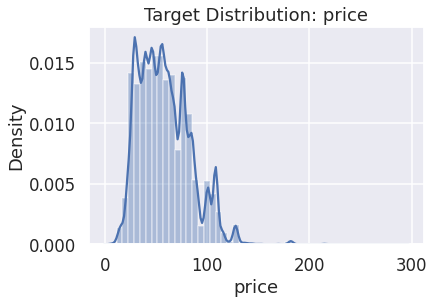

In [ ]:
sns.distplot(y)
plt.title('Target Distribution: '+target)
plt.show()

In [ ]:
y.describe().T

count    199674.000000
mean         58.265872
std          24.821777
min           5.650000
25%          39.250000
50%          55.700000
75%          75.400000
max         290.400000
Name: price, dtype: float64

In [ ]:
X.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
origin,199674,30,MADRID,98262,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination,199674,30,MADRID,99486,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
departure,199674,54857,2019-06-02 17:30:00,50,2019-04-12 09:40:00,2020-12-05 17:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival,199674,63951,2019-05-29 14:20:00,34,2019-04-12 11:24:00,2020-12-05 18:50:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,199674.0,NaN,NaN,NaN,NaT,NaT,2.893705,1.561707,0.37,1.87,2.53,3.13,12.42
vehicle_type,199674,30,AVE,133025,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_class,199674,10,Turista,155486,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,199674,10,Promo,106426,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seats,8418.0,NaN,NaN,NaN,NaT,NaT,220.079116,72.957453,6.0,205.0,238.0,262.0,334.0
insert_date,199674,164263,2020-09-30 20:00:00,105,2019-04-11 21:49:48,2020-10-07 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering

In [ ]:
# Variables de fechas las paso a cuatro variables distintas: día del mes, día de la semana, mes, hora.
for i in ('departure','insert_date'):
  X['weekday_'+i] = X[i].dt.day_name()
  X['weekday_n_'+i] = X[i].dt.day_of_week # 0 -Lunes, 6-Domingo
  X['month_'+i] = X[i].dt.month
  X['hour_'+i] = X[i].dt.hour

In [ ]:
# Tiempo entre la consulta del precio y el viaje
timedelta = X.departure - X.insert_date
X['days_before_trip'] = timedelta.dt.days

In [ ]:
festivos = pd.read_csv('/content/drive/MyDrive/MASTER EN DATA SCIENCE/Módulos master/Módulo 5 - Machine Learning Regresión/Proyecto RENFE/dias_festivos.csv')

In [ ]:
festivos = pd.to_datetime(festivos.values.flatten(), format='%d-%m-%Y')

In [ ]:
X['ind_weekend'] = X.weekday_n_departure.isin([5,6])

In [ ]:
X['ind_holidays'] = X.departure.dt.date.isin(festivos.date)

In [ ]:
X.ind_holidays = X.ind_holidays.astype('int8')
X.ind_weekend = X.ind_weekend.astype('int8')

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199674 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   origin                 199674 non-null  object        
 1   destination            199674 non-null  object        
 2   departure              199674 non-null  datetime64[ns]
 3   arrival                199674 non-null  datetime64[ns]
 4   duration               199674 non-null  float64       
 5   vehicle_type           199674 non-null  object        
 6   vehicle_class          199674 non-null  object        
 7   fare                   199674 non-null  object        
 8   seats                  8418 non-null    float64       
 9   insert_date            199674 non-null  datetime64[ns]
 10  weekday_departure      199674 non-null  object        
 11  weekday_n_departure    199674 non-null  int64         
 12  month_departure        199674 non-null  int6

In [ ]:
# Hipotesis: los precios de las lineas de tren ida y vuelta son parecidos
# Vamos a ponerle nombre a las lineas de tren 
# Definimos que el nombre de la linea será CIUDAD CON MAS VIAJES DE ORIGEN - CIUDAD CON MENOS VIAJES DE ORIGEN

city_order = X.origin.value_counts().index.values

def train_line(origin, destination, city_list):
  if np.where(city_order == origin) < np.where(city_order == destination):
    return origin+'-'+destination
  else:
    return destination+'-'+origin

# Aplicamos la funcion linea a linea en el dataframe
X['train_line'] = X.apply(lambda x: train_line(x['origin'], x['destination'], city_order), axis=1)

In [ ]:
X.head(3)

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,fare,seats,insert_date,...,month_departure,hour_departure,weekday_insert_date,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,train_line
0,MADRID,VALENCIA,2019-08-29 16:55:00,2019-08-29 21:58:00,5.05,AVE-LD,Turista con enlace,Promo,NaN,2019-08-16 12:02:16,...,8,16,Friday,4,8,12,13,0,0,MADRID-VALENCIA
1,BARCELONA,MADRID,2019-04-30 12:50:00,2019-04-30 15:45:00,2.92,AVE-TGV,Turista,Promo,NaN,2019-04-18 22:20:08,...,4,12,Thursday,3,4,22,11,0,0,MADRID-BARCELONA
2,MADRID,MALAGA,2020-04-26 15:35:00,2020-04-26 18:06:00,2.52,AVE,Preferente,Promo,NaN,2020-03-01 03:18:13,...,4,15,Sunday,6,3,3,56,1,0,MADRID-MALAGA


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199674 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   origin                 199674 non-null  object        
 1   destination            199674 non-null  object        
 2   departure              199674 non-null  datetime64[ns]
 3   arrival                199674 non-null  datetime64[ns]
 4   duration               199674 non-null  float64       
 5   vehicle_type           199674 non-null  object        
 6   vehicle_class          199674 non-null  object        
 7   fare                   199674 non-null  object        
 8   seats                  8418 non-null    float64       
 9   insert_date            199674 non-null  datetime64[ns]
 10  weekday_departure      199674 non-null  object        
 11  weekday_n_departure    199674 non-null  int64         
 12  month_departure        199674 non-null  int6

In [ ]:
X.columns

Index(['origin', 'destination', 'departure', 'arrival', 'duration',
       'vehicle_type', 'vehicle_class', 'fare', 'seats', 'insert_date',
       'weekday_departure', 'weekday_n_departure', 'month_departure',
       'hour_departure', 'weekday_insert_date', 'weekday_n_insert_date',
       'month_insert_date', 'hour_insert_date', 'days_before_trip',
       'ind_weekend', 'ind_holidays', 'train_line'],
      dtype='object')

In [ ]:
100*X.vehicle_class.value_counts() / X.shape[0]

Turista                   77.869928
Turista con enlace         9.061270
Preferente                 7.080040
Turista Plus               5.585104
TuristaSólo plaza H        0.313511
PreferenteSólo plaza H     0.040065
Cama Turista               0.037060
Turista Plus - Turista     0.006511
Turista - Turista Plus     0.004507
Cama G. Clase              0.002003
Name: vehicle_class, dtype: float64

## Gestionar Nulos

In [ ]:
100*X.isna().sum()/X.shape[0]

origin                    0.000000
destination               0.000000
departure                 0.000000
arrival                   0.000000
duration                  0.000000
vehicle_type              0.000000
vehicle_class             0.000000
fare                      0.000000
seats                    95.784128
insert_date               0.000000
weekday_departure         0.000000
weekday_n_departure       0.000000
month_departure           0.000000
hour_departure            0.000000
weekday_insert_date       0.000000
weekday_n_insert_date     0.000000
month_insert_date         0.000000
hour_insert_date          0.000000
days_before_trip          0.000000
ind_weekend               0.000000
ind_holidays              0.000000
train_line                0.000000
dtype: float64

In [ ]:
#Funcion de ayuda para tomar decisiones en la gestion de nulos
def column_report(df_x):
    a = pd.DataFrame(df_x.dtypes, columns={'dtype'})
    b = pd.DataFrame(df_x.isna().sum(), columns={'nulls'})
    b['%nulls'] = round(100*b['nulls']/ df_x.shape[0],2)  
    c = df_x.describe(include='all').transpose()
    return a.join(b).join(c).sort_values(by=['dtype','nulls'])

report = column_report(df)

In [ ]:
# Analisis de nulos
pd.set_option('display.max_rows', 1000)
report[report['nulls']>0].sort_values(by='nulls',ascending=False)

,dtype,nulls,%nulls,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
seats,float64,191256,95.78,8418.0,NaN,NaN,NaN,NaT,NaT,220.079116,72.957453,6.0,205.0,238.0,262.0,334.0


Hay varias columnas con altos % de nulos. Como tenemos tantas variables lo aconsejable sería directamente eliminar aquellas con muchos nulos (>50
%). Antes de eliminar ninguna variable vamos a comprobar que no estén altamente correlacionada con el target:

In [ ]:
corr = df.corr()

In [ ]:
corr_list = pd.DataFrame(corr[target].abs().sort_values(ascending=False))
corr_list.rename(columns={target:'correlation'},inplace=True)
corr_list[corr_list['correlation']>0.50]

,correlation
price,1.0


In [ ]:
X.drop(columns='seats',inplace=True)

## One-hot-encoding

In [ ]:
categorical = X.select_dtypes(include='object').columns

In [ ]:
X[categorical].nunique()

origin                 30
destination            30
vehicle_type           30
vehicle_class          10
fare                   10
weekday_departure       7
weekday_insert_date     7
train_line             31
dtype: int64

In [ ]:
for i in categorical:
  print(i)
  print(X[i].value_counts())
  print()

origin
MADRID         98262
BARCELONA      24889
VALENCIA       19751
SEVILLA        19630
CORDOBA         5908
ZARAGOZA        5488
PONFERRADA      4609
VALLADOLID      4351
ALBACETE        2244
MALAGA          2241
TARRAGONA       2238
LLEIDA          1771
GIRONA          1741
ALICANTE        1371
LEON            1307
CASTELLON       1029
GRANADA          739
CÓRDOBA          462
SEGOVIA          257
CIUDAD REAL      230
PALENCIA         191
MÁLAGA           180
CUENCA           155
LEÓN             143
TOLEDO           128
GUADALAJARA      117
CADIZ             78
CASTELLO          63
ZAMORA            56
HUESCA            45
Name: origin, dtype: int64

destination
MADRID         99486
BARCELONA      25899
VALENCIA       20638
SEVILLA        19608
CORDOBA         5586
ZARAGOZA        5567
VALLADOLID      4283
PONFERRADA      3077
MALAGA          2243
ALBACETE        2231
TARRAGONA       2020
GIRONA          1495
ALICANTE        1422
LLEIDA          1370
CASTELLON        995
LEON    

In [ ]:
#Definimos como residual todo valor con una frecuencia por debajo del 5%
min_weight = 0.05

for i in categorical:
  count = X[i].value_counts() / X.shape[0]
  most_frequent = count[count>min_weight].index.to_list()
  X[i] = X[i].apply(lambda x: x if x in most_frequent else 'OTRO')

In [ ]:
# Procedemos al one hot encoding
X = pd.get_dummies(data=X,
                               prefix=None, 
                               prefix_sep="_",
                               columns=categorical,
                               dtype="int8")

In [ ]:
X.head(3)

,departure,arrival,duration,insert_date,weekday_n_departure,month_departure,hour_departure,weekday_n_insert_date,month_insert_date,hour_insert_date,...,weekday_insert_date_Saturday,weekday_insert_date_Sunday,weekday_insert_date_Thursday,weekday_insert_date_Tuesday,weekday_insert_date_Wednesday,train_line_MADRID-BARCELONA,train_line_MADRID-CORDOBA,train_line_MADRID-SEVILLA,train_line_MADRID-VALENCIA,train_line_OTRO
0,2019-08-29 16:55:00,2019-08-29 21:58:00,5.05,2019-08-16 12:02:16,3,8,16,4,8,12,...,0,0,0,0,0,0,0,0,1,0
1,2019-04-30 12:50:00,2019-04-30 15:45:00,2.92,2019-04-18 22:20:08,1,4,12,3,4,22,...,0,0,1,0,0,1,0,0,0,0
2,2020-04-26 15:35:00,2020-04-26 18:06:00,2.52,2020-03-01 03:18:13,6,4,15,6,3,3,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
X.shape

(199674, 55)

In [ ]:
# Eliminamos las columnas antiguas de fechas pues ya no nos sirven
X.drop(columns=["departure", "arrival", "insert_date"], inplace=True)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199674 entries, 0 to 199999
Data columns (total 52 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   duration                          199674 non-null  float64
 1   weekday_n_departure               199674 non-null  int64  
 2   month_departure                   199674 non-null  int64  
 3   hour_departure                    199674 non-null  int64  
 4   weekday_n_insert_date             199674 non-null  int64  
 5   month_insert_date                 199674 non-null  int64  
 6   hour_insert_date                  199674 non-null  int64  
 7   days_before_trip                  199674 non-null  int64  
 8   ind_weekend                       199674 non-null  int8   
 9   ind_holidays                      199674 non-null  int8   
 10  origin_BARCELONA                  199674 non-null  int8   
 11  origin_MADRID                     199674 non-null  i

## Altamente correlacionadas

In [ ]:
# Divide dataset en matriz de variables (X) y output (y)
features = X.columns[X.columns!=target]

In [ ]:
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]
    
    return Z

In [ ]:
# Detectar y elimanamos parejas de variables altamente correlacionadas
highly_corr = highly_correlated(X, y, 0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete


## Eliminar variables baja Varianza

In [ ]:
vt = VarianceThreshold(threshold = 0.01) #Eliminamos columnas donde el 99% de los valores son iguales
vt.fit(X)
cols_lowvar = X.columns[vt.get_support()==False]
X.drop(columns=cols_lowvar,inplace=True)
print(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar)

1  low variance features were removed:
 Index(['vehicle_class_OTRO'], dtype='object')


## Split train-test

Test debe ser 30%

In [ ]:
X.shape

(199674, 51)

In [ ]:
# Divide dataset en matriz de variables (X) y output (y)
features = X.columns[X.columns!=target]

In [ ]:
# Divide X-y en Train (70%) y Test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print("Train: {:,}".format(len(y_train)))
print("Test: {:,}".format(len(y_test)))

Train: 139,771
Test: 59,903


# Torneo de modelos

* Probar regresion Lineal y xgbRegressor al menos
* Utilizar en cada modelo la funcion evaluate_model(model, X_train, y_train, X_test, y_test)

Modelo Regresión Lineal

In [ ]:
X_train3 = X_train.copy()
X_test3 = X_test.copy()
y_train3 = y_train.copy()
y_test3 = y_test.copy()

In [ ]:
# Estandarización: fit_transform() en train, transform() en test
scaler = StandardScaler()
X_train3 = scaler.fit_transform(X_train3) # el fit es para ajustar los datos, calcula la media y varianza del X_train y lo aplica sobre él pero solo a datos entrenados no a los del test.
X_test3 = scaler.transform(X_test3)

In [ ]:
X_train3

array([[-0.41311359,  1.59644327, -0.28066745, ..., -0.49432339,
         2.01234449, -0.65949385],
       [-0.09402963,  1.08835996, -0.72026415, ..., -0.49432339,
        -0.49693281, -0.65949385],
       [-0.23442657, -0.94397329,  0.15892925, ...,  2.02296719,
        -0.49693281, -0.65949385],
       ...,
       [-0.17060978, -0.94397329, -1.15986084, ...,  2.02296719,
        -0.49693281, -0.65949385],
       [-0.98746471,  0.07219333, -1.15986084, ..., -0.49432339,
        -0.49693281,  1.51631436],
       [ 1.50139016,  0.07219333, -0.72026415, ..., -0.49432339,
        -0.49693281, -0.65949385]])

In [ ]:
X_test3

array([[ 3.9391916 , -1.4520566 ,  2.79650944, ..., -0.49432339,
        -0.49693281, -0.65949385],
       [-0.15784642, -1.4520566 , -0.72026415, ..., -0.49432339,
        -0.49693281,  1.51631436],
       [-0.87259449, -1.4520566 , -1.15986084, ..., -0.49432339,
        -0.49693281,  1.51631436],
       ...,
       [-0.23442657,  0.58027665,  1.47771935, ...,  2.02296719,
        -0.49693281, -0.65949385],
       [-0.09402963,  0.58027665, -0.28066745, ..., -0.49432339,
        -0.49693281, -0.65949385],
       [-0.09402963,  1.59644327, -0.28066745, ..., -0.49432339,
        -0.49693281, -0.65949385]])

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train3,y_train3)

LinearRegression()

In [ ]:
lin_reg.coef_

array([ 9.41311085e-01,  3.66112027e+13, -2.73862475e+00, -8.32413717e-02,
       -5.51934277e+12,  2.28796161e+00, -5.48596231e-03, -4.30465718e-01,
       -2.34240916e+13,  1.45567111e-01, -3.52689414e+13, -5.34088585e+13,
        1.41435186e+13,  7.28091449e+13,  1.08558721e+13,  3.04670518e+13,
        4.52934289e+13,  8.81468224e+13,  1.31457143e+14,  7.10412775e+13,
       -3.32795616e+13, -6.24504877e+13, -5.85320893e+13,  3.50184614e+00,
       -2.45359379e+00,  7.11164065e-01, -7.32143426e-01, -1.70821184e+13,
       -2.70090232e+13, -6.46548749e+12, -2.99743008e+13, -1.68122658e+13,
       -1.53082442e+12,  2.51271881e+13,  1.00237778e+13,  4.40392082e+12,
        5.16769750e+12,  1.84594664e+13,  1.17720268e+13, -7.46806326e+12,
       -1.07690171e+13, -6.61707088e+12, -5.16417789e+12, -8.39544615e+12,
       -1.00387648e+13, -9.37183886e+12,  1.13826167e+14,  2.82624096e+13,
       -3.44587991e+13,  4.83930711e+13,  5.58098981e+13])

In [ ]:
# Fórmula de la regresión lineal sobre las variables estandarizadas
print("MODEL:")  # son variables estandarizadas
print(target+" = "+" ".join(i+' x '+str(round(j,1))+' + ' for i,j in zip(X.columns.values,lin_reg.coef_))+str(round(lin_reg.intercept_,1)))

MODEL:
price = duration x 0.9 +  weekday_n_departure x 36611202726999.0 +  month_departure x -2.7 +  hour_departure x -0.1 +  weekday_n_insert_date x -5519342772730.9 +  month_insert_date x 2.3 +  hour_insert_date x -0.0 +  days_before_trip x -0.4 +  ind_weekend x -23424091611343.3 +  ind_holidays x 0.1 +  origin_BARCELONA x -35268941422882.1 +  origin_MADRID x -53408858488542.2 +  origin_OTRO x 14143518571531.8 +  origin_SEVILLA x 72809144932629.3 +  origin_VALENCIA x 10855872075782.9 +  destination_BARCELONA x 30467051790506.2 +  destination_MADRID x 45293428923015.9 +  destination_OTRO x 88146822444805.2 +  destination_SEVILLA x 131457142892406.8 +  destination_VALENCIA x 71041277507002.2 +  vehicle_type_ALVIA x -33279561573040.4 +  vehicle_type_AVE x -62450487697707.2 +  vehicle_type_OTRO x -58532089311763.6 +  vehicle_class_Preferente x 3.5 +  vehicle_class_Turista x -2.5 +  vehicle_class_Turista Plus x 0.7 +  vehicle_class_Turista con enlace x -0.7 +  fare_Adulto ida x -170821183

In [ ]:
#Predicción sobre X test
y_pred = lin_reg.predict(X_test3)

In [ ]:
error = y_pred - y_test.values

In [ ]:
RMSE = np.sqrt(np.mean(error**2))
RMSE 

13.161872362917595

Modelo XGBReg

In [ ]:
model_XGBReg = xgb.XGBRegressor(colsample_bytree=0.5, n_estimators=500, objective='reg:squarederror')

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)] 
model_XGBReg.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = eval_set, 
    verbose = False
)

XGBRegressor(colsample_bytree=0.5, n_estimators=500,
             objective='reg:squarederror')

In [ ]:
y_pred_train = model_XGBReg.predict(X_train)
rmse_train = np.sqrt(np.mean((y_pred_train - y_train) ** 2))

y_pred_test = model_XGBReg.predict(X_test)
rmse_test = np.sqrt(np.mean((y_pred_test - y_test) ** 2))

print("RMSE Train: %.3f" %rmse_train)
print("RMSE Test: %.3f" %rmse_test)

RMSE Train: 8.193
RMSE Test: 8.170


In [ ]:
# Nos quedamos con el modelo XGBReg que da mejores resultados: 8.1 frente a 13.1  A continuación hiperparametrizamos

# Hiperparametrizacion: GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_GS = xgb.XGBRegressor()  #ahora XGBRegresssor

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower Son los parámetros que utilizará y dara el mejor modelo con un comando posterior
              'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05], #so called `eta` value
              'max_depth': [3, 5, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.5,0.7],
              'n_estimators': [100,500,1000]}


In [ ]:
xgb_grid = GridSearchCV(xgb_GS,
                        parameters,
                        cv=2,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2, estimator=XGBRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.03, 0.05], 'max_depth': [3, 5, 7],
                         'min_child_weight': [4],
                         'n_estimators': [100, 500, 1000], 'nthread': [4],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.7]},
             verbose=True)

In [ ]:
# Best model (XGBoost hiperparametrizado)   
model_XGBReg_hp = xgb_grid.best_estimator_       
model_XGBReg_hp

XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=7,
             min_child_weight=4, n_estimators=1000, nthread=4,
             objective='reg:squarederror', subsample=0.7)

In [ ]:
#Prediction and metrics
y_pred_train = model_XGBReg_hp.predict(X_train)
rmse_train = np.sqrt(np.mean((y_pred_train - y_train) ** 2))

y_pred_test = model_XGBReg_hp.predict(X_test)
rmse_test = np.sqrt(np.mean((y_pred_test - y_test) ** 2))

print("RMSE Train: %.3f" %rmse_train)
print("RMSE Test: %.3f" %rmse_test)

RMSE Train: 4.941
RMSE Test: 5.661


In [ ]:
# El error baja bastante

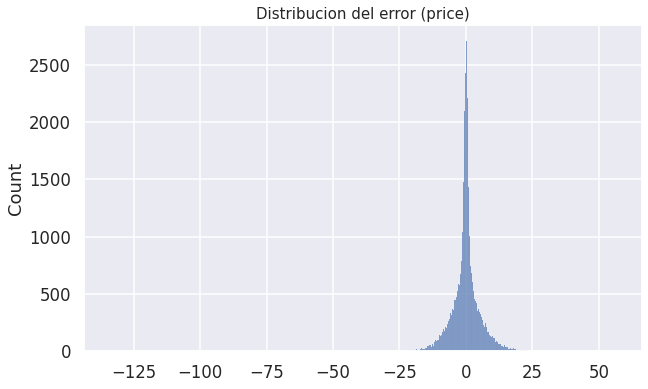

In [ ]:
#Error distribution
error = y_pred_test - y_test.values
plt.figure(figsize=(10, 6))
plt.title('Distribucion del error (price)', fontsize=15)
sns.histplot(error)
plt.show()

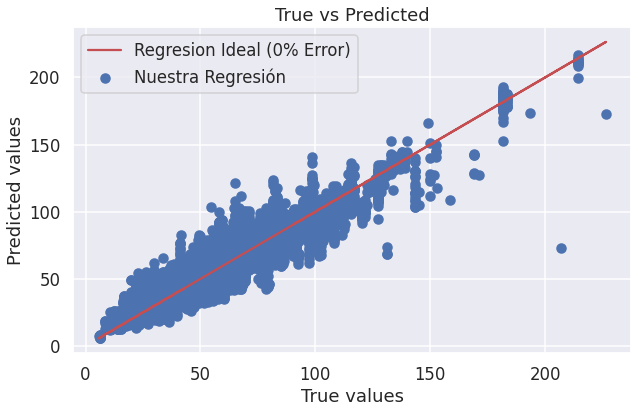

In [ ]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(y_test,y_pred_test)
plt.plot(y_test,y_test,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

In [ ]:
# el error es una campana de gauss perfectamente normalizada lo cual da idea de que el modelo es correcto

# Interpretabilidad del modelo

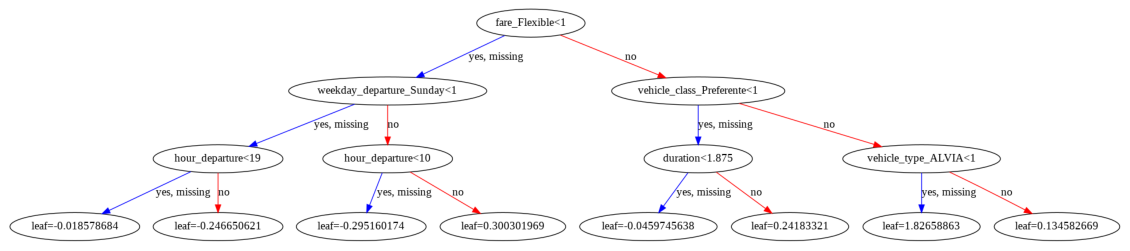

In [ ]:
# Visualiza un árbol concreto de los [n_estimators] que utiliza el XGBoost
plt.rcParams["figure.figsize"] =[20, 10]
plot_tree(model_XGBReg, num_trees=50)
plt.show()

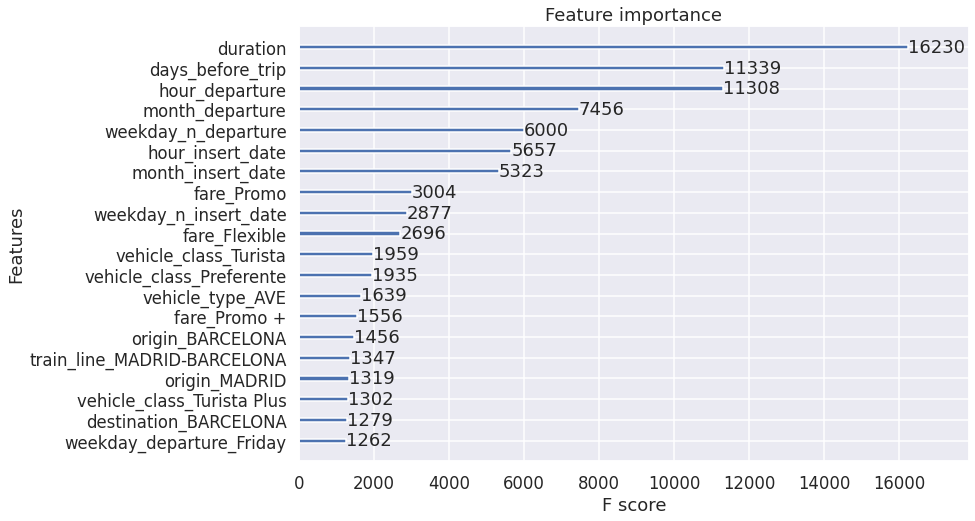

In [ ]:
# Feature importance: numero de veces que emplea la variable para determinar el output
rcParams['figure.figsize'] = 12,8
sns.set(context="talk")
xgb.plot_importance(model_XGBReg_hp, max_num_features=20, importance_type='weight')
plt.show()

In [ ]:
# Las variables más importantes que obtenemos son: la duración, el tiempo antes del viaje, mes, hora y día de la salida.

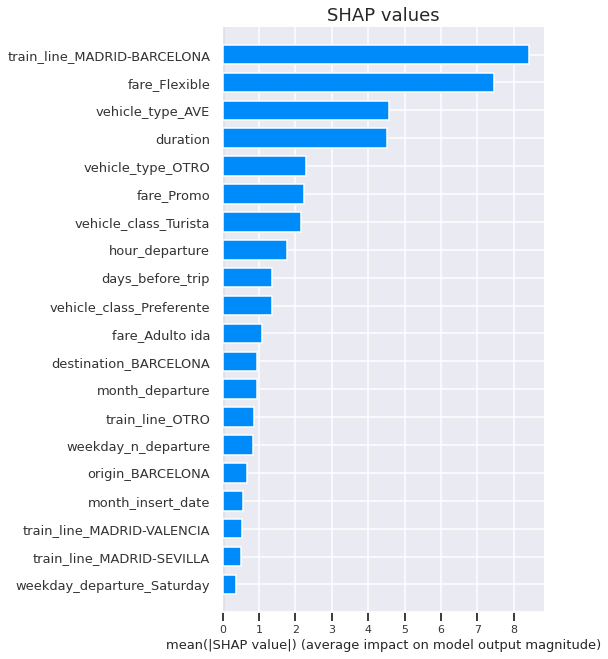

In [ ]:
#SHAP value: peso en el output final,  impacto promedio en el output
explainer = shap.TreeExplainer(model_XGBReg_hp)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

In [ ]:
# Respecto al output donde se tiene más impacto de media es en el tren línea Madrid-Barcelona, la tarifa flexible, el tren AVE y la duración.

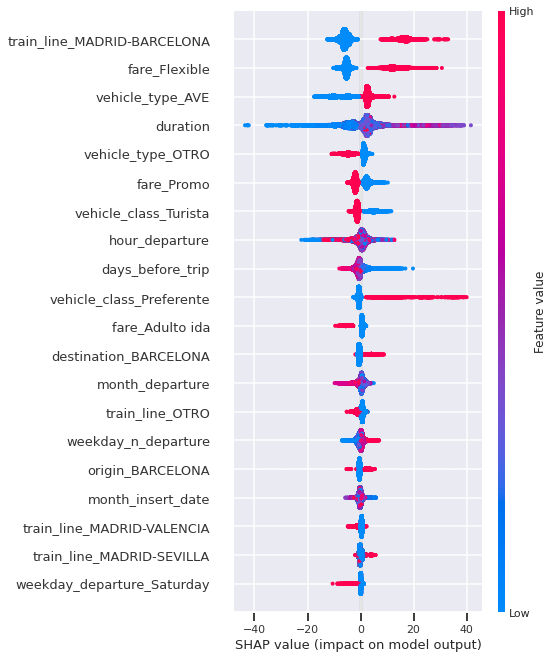

In [ ]:
shap.summary_plot(shap_values, X_test)

# Predict

## OPCION A) Generar listado de predicts

Se pide hacer predicciones de precio para los datos de validacion y calcular el RMSE en validacion
Hay que replicar pasos del preprocessing en dataset validacion:

Cambios de formato,
Feature Engineering,
One hot encoding,
Eliminacion de columnas,
Estandarizacion de X (aplicar el mismo .transform)

In [ ]:
X_pred = pd.read_csv('/content/drive/MyDrive/MASTER EN DATA SCIENCE/Módulos master/Módulo 5 - Machine Learning Regresión/Proyecto RENFE/renfe_predict.csv')

In [ ]:
X_pred.head(3)

,Unnamed: 0,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,fare,seats,insert_date
0,24011276,CORDOBA,MADRID,2020-04-01 08:56:00,2020-04-01 10:40:00,1.73,AVE,Turista,Flexible,NaN,2020-03-08 03:08:51
1,8680912,SEVILLA,MADRID,2019-07-05 16:15:00,2019-07-05 18:54:00,2.65,AVE,Turista,Promo,NaN,2019-05-29 09:32:34
2,15196259,VALENCIA,MADRID,2019-09-04 10:40:00,2019-09-04 13:05:00,2.42,INTERCITY,Turista,Promo,NaN,2019-08-21 19:51:20


In [ ]:
X_pred.shape

(40000, 11)

In [ ]:
X.columns.to_list()

['duration',
 'weekday_n_departure',
 'month_departure',
 'hour_departure',
 'weekday_n_insert_date',
 'month_insert_date',
 'hour_insert_date',
 'days_before_trip',
 'ind_weekend',
 'ind_holidays',
 'origin_BARCELONA',
 'origin_MADRID',
 'origin_OTRO',
 'origin_SEVILLA',
 'origin_VALENCIA',
 'destination_BARCELONA',
 'destination_MADRID',
 'destination_OTRO',
 'destination_SEVILLA',
 'destination_VALENCIA',
 'vehicle_type_ALVIA',
 'vehicle_type_AVE',
 'vehicle_type_OTRO',
 'vehicle_class_Preferente',
 'vehicle_class_Turista',
 'vehicle_class_Turista Plus',
 'vehicle_class_Turista con enlace',
 'fare_Adulto ida',
 'fare_Flexible',
 'fare_OTRO',
 'fare_Promo',
 'fare_Promo +',
 'weekday_departure_Friday',
 'weekday_departure_Monday',
 'weekday_departure_Saturday',
 'weekday_departure_Sunday',
 'weekday_departure_Thursday',
 'weekday_departure_Tuesday',
 'weekday_departure_Wednesday',
 'weekday_insert_date_Friday',
 'weekday_insert_date_Monday',
 'weekday_insert_date_Saturday',
 'weekday

In [ ]:
X_ejemplo = X.sample(n=4,random_state=30)
X_ejemplo

,duration,weekday_n_departure,month_departure,hour_departure,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,...,weekday_insert_date_Saturday,weekday_insert_date_Sunday,weekday_insert_date_Thursday,weekday_insert_date_Tuesday,weekday_insert_date_Wednesday,train_line_MADRID-BARCELONA,train_line_MADRID-CORDOBA,train_line_MADRID-SEVILLA,train_line_MADRID-VALENCIA,train_line_OTRO
182912,2.68,1,8,20,3,7,10,54,0,0,...,0,0,1,0,0,0,0,0,0,1
119006,2.35,1,3,7,0,2,5,50,0,0,...,0,0,0,0,0,0,0,1,0,0
29315,1.78,3,8,18,5,6,3,47,0,0,...,1,0,0,0,0,0,0,0,1,0
71684,1.05,0,3,10,6,3,2,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
predictions = model_XGBReg.predict(X_ejemplo)

In [ ]:
df_output = X_ejemplo.copy(deep=True)
df_output['PREDICTION Price'] = predictions
df_output

,duration,weekday_n_departure,month_departure,hour_departure,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,...,weekday_insert_date_Sunday,weekday_insert_date_Thursday,weekday_insert_date_Tuesday,weekday_insert_date_Wednesday,train_line_MADRID-BARCELONA,train_line_MADRID-CORDOBA,train_line_MADRID-SEVILLA,train_line_MADRID-VALENCIA,train_line_OTRO,PREDICTION Price
182912,2.68,1,8,20,3,7,10,54,0,0,...,0,1,0,0,0,0,0,0,1,74.777313
119006,2.35,1,3,7,0,2,5,50,0,0,...,0,0,0,0,0,0,1,0,0,56.800602
29315,1.78,3,8,18,5,6,3,47,0,0,...,0,0,0,0,0,0,0,1,0,37.231159
71684,1.05,0,3,10,6,3,2,1,0,0,...,1,0,0,0,0,0,0,0,1,34.181267


In [ ]:
# El modelo predice bien pues ha sido bien entrenado. Ahora pondremos el dataset de predicción y haremos todo el proceso de nuevo

**Hay que replicar pasos del preprocessing en dataset validacion**
1. Cambios de formato
2. Feature Engineering
3. One hot encoding
4. Eliminacion de columnas
5. Estandarizacion de X (aplicar el mismo .transform)

In [ ]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     40000 non-null  int64  
 1   origin         40000 non-null  object 
 2   destination    40000 non-null  object 
 3   departure      40000 non-null  object 
 4   arrival        40000 non-null  object 
 5   duration       40000 non-null  float64
 6   vehicle_type   40000 non-null  object 
 7   vehicle_class  40000 non-null  object 
 8   fare           40000 non-null  object 
 9   seats          1658 non-null   float64
 10  insert_date    40000 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.4+ MB


In [ ]:
X_pred

,Unnamed: 0,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,fare,seats,insert_date
0,24011276,CORDOBA,MADRID,2020-04-01 08:56:00,2020-04-01 10:40:00,1.73,AVE,Turista,Flexible,NaN,2020-03-08 03:08:51
1,8680912,SEVILLA,MADRID,2019-07-05 16:15:00,2019-07-05 18:54:00,2.65,AVE,Turista,Promo,NaN,2019-05-29 09:32:34
2,15196259,VALENCIA,MADRID,2019-09-04 10:40:00,2019-09-04 13:05:00,2.42,INTERCITY,Turista,Promo,NaN,2019-08-21 19:51:20
3,7546377,BARCELONA,MADRID,2019-05-24 06:25:00,2019-05-24 08:55:00,2.50,AVE,Turista,Promo,NaN,2019-05-23 15:24:38
4,17178061,PONFERRADA,MADRID,2020-04-02 06:11:00,2020-04-02 12:00:00,5.82,LD,Turista con enlace,Flexible,NaN,2020-02-10 12:15:28
...,...,...,...,...,...,...,...,...,...,...,...
39995,57627,MADRID,SEVILLA,2019-05-07 14:00:00,2019-05-07 16:32:00,2.53,AVE,Turista,Promo,NaN,2019-04-12 03:04:45
39996,36455665,MADRID,TARRAGONA,2020-08-23 17:30:00,2020-08-23 20:03:00,2.55,AVE,Turista,Flexible,NaN,2020-07-06 22:19:58
39997,8863281,SEVILLA,MADRID,2019-07-16 13:40:00,2019-07-16 16:10:00,2.50,AVE,Turista,Promo,NaN,2019-05-30 09:25:49
39998,11748101,SEVILLA,MADRID,2019-08-09 12:40:00,2019-08-09 15:23:00,2.72,AVE,Turista,Promo,NaN,2019-06-15 15:05:44


In [ ]:
# Gestión_duplicados
print(X_pred.duplicated().sum(),'duplicated rows were deleted')
X_pred.drop_duplicates(inplace=True)
print(X_pred.shape)

0 duplicated rows were deleted
(40000, 11)


In [ ]:
#Funcion de ayuda para tomar decisiones en la gestion de nulos
def column_report(df_x):
    a = pd.DataFrame(df_x.dtypes, columns={'dtype'})
    b = pd.DataFrame(df_x.isna().sum(), columns={'nulls'})
    b['%nulls'] = round(100*b['nulls']/ df_x.shape[0],2)  
    c = df_x.describe(include='all').transpose()
    return a.join(b).join(c).sort_values(by=['dtype','nulls'])

report = column_report(X_pred)

In [ ]:
# Analisis de nulos
pd.set_option('display.max_rows', 1000)
report[report['nulls']>0].sort_values(by='nulls',ascending=False)

,dtype,nulls,%nulls,count,unique,top,freq,mean,std,min,25%,50%,75%,max
seats,float64,38342,95.86,1658.0,NaN,NaN,NaN,220.913752,71.982248,6.0,205.25,236.0,261.0,334.0


In [ ]:
#procedemos a eliminar la columna seats por la gran cantidad de nulos que tiene
del(X_pred['seats'])

In [ ]:
# Pasar fechas de tipo objeto a tipo datetime
for i in ('departure','arrival','insert_date'):
  X_pred[i] = pd.to_datetime(X_pred[i])

In [ ]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     40000 non-null  int64         
 1   origin         40000 non-null  object        
 2   destination    40000 non-null  object        
 3   departure      40000 non-null  datetime64[ns]
 4   arrival        40000 non-null  datetime64[ns]
 5   duration       40000 non-null  float64       
 6   vehicle_type   40000 non-null  object        
 7   vehicle_class  40000 non-null  object        
 8   fare           40000 non-null  object        
 9   insert_date    40000 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1), object(5)
memory usage: 3.4+ MB


In [ ]:
# Variables de las fechas
for i in ('departure','insert_date'):
  X_pred['weekday_'+i] = X_pred[i].dt.day_name()
  X_pred['weekday_n_'+i] = X_pred[i].dt.day_of_week # 0-Lunes, 6-Domingo
  X_pred['month_'+i] = X_pred[i].dt.month
  X_pred['hour_'+i] = X_pred[i].dt.hour

In [ ]:
# Tiempo entre la consulta del precio y el viaje
timedelta = X_pred.departure - X_pred.insert_date
X_pred['days_before_trip'] = timedelta.dt.days

In [ ]:
X_pred['ind_weekend'] = X_pred.weekday_n_departure.isin([5,6])

In [ ]:
X_pred['ind_holidays'] = X_pred.departure.dt.date.isin(festivos.date)

In [ ]:
X_pred.ind_holidays = X_pred.ind_holidays.astype('int8')
X_pred.ind_weekend = X_pred.ind_weekend.astype('int8')

In [ ]:
del(X_pred['Unnamed: 0'])

In [ ]:
X_pred.columns

Index(['origin', 'destination', 'departure', 'arrival', 'duration',
       'vehicle_type', 'vehicle_class', 'fare', 'insert_date',
       'weekday_departure', 'weekday_n_departure', 'month_departure',
       'hour_departure', 'weekday_insert_date', 'weekday_n_insert_date',
       'month_insert_date', 'hour_insert_date', 'days_before_trip',
       'ind_weekend', 'ind_holidays'],
      dtype='object')

In [ ]:
X_pred.origin.value_counts().index.values #ordena la frequencia de origen

array(['MADRID', 'BARCELONA', 'VALENCIA', 'SEVILLA', 'CORDOBA',
       'ZARAGOZA', 'PONFERRADA', 'VALLADOLID', 'ALBACETE', 'TARRAGONA',
       'MALAGA', 'LLEIDA', 'GIRONA', 'LEON', 'ALICANTE', 'CASTELLON',
       'GRANADA', 'CÓRDOBA', 'SEGOVIA', 'LEÓN', 'PALENCIA', 'CIUDAD REAL',
       'MÁLAGA', 'CUENCA', 'GUADALAJARA', 'TOLEDO', 'CADIZ', 'ZAMORA',
       'HUESCA', 'CASTELLO'], dtype=object)

In [ ]:
# Hipotesis: los precios de las lineas de tren ida y vuelta son parecidos
# Vamos a ponerle nombre a las lineas de tren 
# Definimos que el nombre de la linea será CIUDAD CON MAS VIAJES DE ORIGEN - CIUDAD CON MENOS VIAJES DE ORIGEN

city_order = X_pred.origin.value_counts().index.values

def train_line(origin, destination, city_list):
  if np.where(city_order == origin) < np.where(city_order == destination):
    return origin+'-'+destination
  else:
    return destination+'-'+origin

# Aplicamos la funcion linea a linea en el dataframe
X_pred['train_line'] = X_pred.apply(lambda x: train_line(x['origin'], x['destination'], city_order), axis=1)

In [ ]:
X_pred.head()

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,fare,insert_date,weekday_departure,...,month_departure,hour_departure,weekday_insert_date,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,train_line
0,CORDOBA,MADRID,2020-04-01 08:56:00,2020-04-01 10:40:00,1.73,AVE,Turista,Flexible,2020-03-08 03:08:51,Wednesday,...,4,8,Sunday,6,3,3,24,0,0,MADRID-CORDOBA
1,SEVILLA,MADRID,2019-07-05 16:15:00,2019-07-05 18:54:00,2.65,AVE,Turista,Promo,2019-05-29 09:32:34,Friday,...,7,16,Wednesday,2,5,9,37,0,0,MADRID-SEVILLA
2,VALENCIA,MADRID,2019-09-04 10:40:00,2019-09-04 13:05:00,2.42,INTERCITY,Turista,Promo,2019-08-21 19:51:20,Wednesday,...,9,10,Wednesday,2,8,19,13,0,0,MADRID-VALENCIA
3,BARCELONA,MADRID,2019-05-24 06:25:00,2019-05-24 08:55:00,2.50,AVE,Turista,Promo,2019-05-23 15:24:38,Friday,...,5,6,Thursday,3,5,15,0,0,0,MADRID-BARCELONA
4,PONFERRADA,MADRID,2020-04-02 06:11:00,2020-04-02 12:00:00,5.82,LD,Turista con enlace,Flexible,2020-02-10 12:15:28,Thursday,...,4,6,Monday,0,2,12,51,0,0,MADRID-PONFERRADA


In [ ]:
# vamos a ver las variables que más tipos tienen
100*X_pred.vehicle_class.value_counts()/X_pred.shape[0]

Turista                   78.1950
Turista con enlace         8.8325
Preferente                 7.1050
Turista Plus               5.4375
TuristaSólo plaza H        0.3200
Cama Turista               0.0550
PreferenteSólo plaza H     0.0350
Turista Plus - Turista     0.0075
Cama G. Clase              0.0075
Turista - Turista Plus     0.0050
Name: vehicle_class, dtype: float64

In [ ]:
X_pred.shape

(40000, 21)

In [ ]:
X_pred.isnull().sum()

origin                   0
destination              0
departure                0
arrival                  0
duration                 0
vehicle_type             0
vehicle_class            0
fare                     0
insert_date              0
weekday_departure        0
weekday_n_departure      0
month_departure          0
hour_departure           0
weekday_insert_date      0
weekday_n_insert_date    0
month_insert_date        0
hour_insert_date         0
days_before_trip         0
ind_weekend              0
ind_holidays             0
train_line               0
dtype: int64

In [ ]:
categorical = X_pred.select_dtypes(include='object').columns

In [ ]:
X_pred[categorical].nunique()

origin                 30
destination            30
vehicle_type           30
vehicle_class          10
fare                    9
weekday_departure       7
weekday_insert_date     7
train_line             31
dtype: int64

In [ ]:
for i in categorical:
  print(i)
  print(100*X_pred[i].value_counts()/X_pred.shape[0])
  print()

origin
MADRID         49.3175
BARCELONA      12.5625
VALENCIA        9.9250
SEVILLA         9.8150
CORDOBA         2.9275
ZARAGOZA        2.8225
PONFERRADA      2.2875
VALLADOLID      2.2600
ALBACETE        1.1050
TARRAGONA       1.0775
MALAGA          1.0625
LLEIDA          0.8225
GIRONA          0.7725
LEON            0.7250
ALICANTE        0.6225
CASTELLON       0.5325
GRANADA         0.3525
CÓRDOBA         0.2550
SEGOVIA         0.1400
LEÓN            0.0950
PALENCIA        0.0900
CIUDAD REAL     0.0825
MÁLAGA          0.0800
CUENCA          0.0725
GUADALAJARA     0.0575
TOLEDO          0.0450
CADIZ           0.0325
ZAMORA          0.0225
HUESCA          0.0200
CASTELLO        0.0175
Name: origin, dtype: float64

destination
MADRID         49.6750
BARCELONA      13.1475
VALENCIA       10.0825
SEVILLA         9.7275
CORDOBA         2.9300
ZARAGOZA        2.7225
VALLADOLID      2.1350
PONFERRADA      1.5925
MALAGA          1.1625
ALBACETE        1.1475
TARRAGONA       1.0950
ALICANTE

In [ ]:
#Definimos como residual todo valor con una frecuencia por debajo del 5%
min_weight = 0.05

for i in categorical:
  count = X_pred[i].value_counts() / X_pred.shape[0]
  most_frequent = count[count>0.05].index.to_list()
  X_pred[i] = X_pred[i].apply(lambda x: x if x in most_frequent else 'OTRO')

In [ ]:
for i in categorical:
  print(i)
  print(100*X_pred[i].value_counts()/X_pred.shape[0])
  print()

origin
MADRID       49.3175
OTRO         18.3800
BARCELONA    12.5625
VALENCIA      9.9250
SEVILLA       9.8150
Name: origin, dtype: float64

destination
MADRID       49.6750
OTRO         17.3675
BARCELONA    13.1475
VALENCIA     10.0825
SEVILLA       9.7275
Name: destination, dtype: float64

vehicle_type
AVE      66.7925
OTRO     26.6600
ALVIA     6.5475
Name: vehicle_type, dtype: float64

vehicle_class
Turista               78.1950
Turista con enlace     8.8325
Preferente             7.1050
Turista Plus           5.4375
OTRO                   0.4300
Name: vehicle_class, dtype: float64

fare
Promo         53.3600
Flexible      28.2525
Adulto ida     8.8875
Promo +        8.3650
OTRO           1.1350
Name: fare, dtype: float64

weekday_departure
Thursday     15.4200
Tuesday      15.3475
Monday       15.1475
Friday       15.0725
Wednesday    15.0175
Sunday       13.0825
Saturday     10.9125
Name: weekday_departure, dtype: float64

weekday_insert_date
Saturday     15.9400
Friday       15

In [ ]:
# one hot coding

In [ ]:
X_pred = pd.get_dummies(data=X_pred,
                               prefix=None, 
                               prefix_sep="_",
                               columns=categorical,
                               dtype="int8")

In [ ]:
X_pred.isnull().sum()

departure                           0
arrival                             0
duration                            0
insert_date                         0
weekday_n_departure                 0
month_departure                     0
hour_departure                      0
weekday_n_insert_date               0
month_insert_date                   0
hour_insert_date                    0
days_before_trip                    0
ind_weekend                         0
ind_holidays                        0
origin_BARCELONA                    0
origin_MADRID                       0
origin_OTRO                         0
origin_SEVILLA                      0
origin_VALENCIA                     0
destination_BARCELONA               0
destination_MADRID                  0
destination_OTRO                    0
destination_SEVILLA                 0
destination_VALENCIA                0
vehicle_type_ALVIA                  0
vehicle_type_AVE                    0
vehicle_type_OTRO                   0
vehicle_clas

In [ ]:
X_pred.drop(columns=["departure", "arrival", "insert_date"], inplace=True)

In [ ]:
X_pred.columns

Index(['duration', 'weekday_n_departure', 'month_departure', 'hour_departure',
       'weekday_n_insert_date', 'month_insert_date', 'hour_insert_date',
       'days_before_trip', 'ind_weekend', 'ind_holidays', 'origin_BARCELONA',
       'origin_MADRID', 'origin_OTRO', 'origin_SEVILLA', 'origin_VALENCIA',
       'destination_BARCELONA', 'destination_MADRID', 'destination_OTRO',
       'destination_SEVILLA', 'destination_VALENCIA', 'vehicle_type_ALVIA',
       'vehicle_type_AVE', 'vehicle_type_OTRO', 'vehicle_class_OTRO',
       'vehicle_class_Preferente', 'vehicle_class_Turista',
       'vehicle_class_Turista Plus', 'vehicle_class_Turista con enlace',
       'fare_Adulto ida', 'fare_Flexible', 'fare_OTRO', 'fare_Promo',
       'fare_Promo +', 'weekday_departure_Friday', 'weekday_departure_Monday',
       'weekday_departure_Saturday', 'weekday_departure_Sunday',
       'weekday_departure_Thursday', 'weekday_departure_Tuesday',
       'weekday_departure_Wednesday', 'weekday_insert_date_Fr

In [ ]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   duration                          40000 non-null  float64
 1   weekday_n_departure               40000 non-null  int64  
 2   month_departure                   40000 non-null  int64  
 3   hour_departure                    40000 non-null  int64  
 4   weekday_n_insert_date             40000 non-null  int64  
 5   month_insert_date                 40000 non-null  int64  
 6   hour_insert_date                  40000 non-null  int64  
 7   days_before_trip                  40000 non-null  int64  
 8   ind_weekend                       40000 non-null  int8   
 9   ind_holidays                      40000 non-null  int8   
 10  origin_BARCELONA                  40000 non-null  int8   
 11  origin_MADRID                     40000 non-null  int8   
 12  orig

In [ ]:
# variables entre si altamente correlaconados, no hay ninguna

In [ ]:
highly_corr = highly_correlated(X, y, 0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete


In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
vt = VarianceThreshold(threshold = 0.01) #Eliminamos columnas donde el 99% de los valores son iguales
vt.fit(X_pred)

cols_lowvar = X_pred.columns[vt.get_support()==False]
X_pred.drop(columns=cols_lowvar,inplace=True)

print(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar)

1  low variance features were removed:
 Index(['vehicle_class_OTRO'], dtype='object')


In [ ]:
# predicciones

In [ ]:
predictions = model_XGBReg.predict(X_pred)

In [ ]:
df_output2 = X_pred.copy(deep=True)
df_output2['PREDICTION Price'] = predictions
df_output2

,duration,weekday_n_departure,month_departure,hour_departure,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,...,weekday_insert_date_Sunday,weekday_insert_date_Thursday,weekday_insert_date_Tuesday,weekday_insert_date_Wednesday,train_line_MADRID-BARCELONA,train_line_MADRID-CORDOBA,train_line_MADRID-SEVILLA,train_line_MADRID-VALENCIA,train_line_OTRO,PREDICTION Price
0,1.73,2,4,8,6,3,3,24,0,0,...,1,0,0,0,0,1,0,0,0,63.132103
1,2.65,4,7,16,2,5,9,37,0,0,...,0,0,0,1,0,0,1,0,0,51.808384
2,2.42,2,9,10,2,8,19,13,0,0,...,0,0,0,1,0,0,0,1,0,34.022907
3,2.50,4,5,6,3,5,15,0,0,0,...,0,1,0,0,1,0,0,0,0,86.864960
4,5.82,3,4,6,0,2,12,51,0,0,...,0,0,0,0,0,0,0,0,1,60.406658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2.53,1,5,14,4,4,3,25,0,0,...,0,0,0,0,0,0,1,0,0,49.542583
39996,2.55,6,8,17,0,7,22,47,1,0,...,0,0,0,0,0,0,0,0,1,80.120613
39997,2.50,1,7,13,3,5,9,47,0,0,...,0,1,0,0,0,0,1,0,0,46.921906
39998,2.72,4,8,12,5,6,15,54,0,0,...,0,0,0,0,0,0,1,0,0,43.171589


In [ ]:
y_pred = []

In [ ]:
y_pred = df_output2['PREDICTION Price']

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

In [ ]:
# ahora estandarizamos

In [ ]:
scaler = StandardScaler()
X_train5 = scaler.fit_transform(X_train4)
X_test5 = scaler.transform(X_test4)

In [ ]:
# de nuevo usamos el método XGBReg

In [ ]:
model_XGBReg = xgb.XGBRegressor(colsample_bytree=0.5, n_estimators=500, objective='reg:squarederror')

In [ ]:
eval_set = [(X_train5, y_train4), (X_test5, y_test4)] 
model_XGBReg.fit(
    X_train5, 
    y_train4, 
    eval_metric = "rmse", 
    eval_set = eval_set,
    verbose=False
)

XGBRegressor(colsample_bytree=0.5, n_estimators=500,
             objective='reg:squarederror')

In [ ]:
# y finalmente obtenemos el error más pequeño de todo el dataset y por tanto subiremos el modelo final a un fichero

In [ ]:
y_pred_train = model_XGBReg.predict(X_train5)
rmse_train = np.sqrt(np.mean((y_pred_train - y_train4) ** 2))

y_pred_test = model_XGBReg.predict(X_test5)
rmse_test = np.sqrt(np.mean((y_pred_test - y_test4) ** 2))

print("RMSE Train: %.3f" %rmse_train)
print("RMSE Test: %.3f" %rmse_test)

RMSE Train: 1.722
RMSE Test: 1.863


In [ ]:
y_pred.to_csv('/content/drive/MyDrive/MASTER EN DATA SCIENCE/Módulos master/Módulo 5 - Machine Learning Regresión/Proyecto RENFE/y_pred.csv')

**FIN**